# Recurrent Neural Network - LSTM -  BTC

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

### Loading the Data

In [20]:
df = pd.read_csv("btc-2015-2022.csv")
df

,Date,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
0,4/9/2015,244.751007,246.117996,239.399994,243.675995,2.164350e+07,41.702661,253.715583,251.953281
1,4/10/2015,243.694000,243.694000,232.770996,236.072006,2.888200e+07,37.649141,252.035242,251.638800
2,4/11/2015,236.016007,239.537003,234.175003,236.552002,1.636520e+07,38.056357,250.560648,251.340051
3,4/12/2015,236.535004,237.727997,233.494995,236.153000,1.238790e+07,37.836271,249.188491,251.039318
4,4/13/2015,235.949997,236.934998,221.996002,224.587006,3.118180e+07,32.075186,246.845492,250.515510
...,...,...,...,...,...,...,...,...,...
2818,12/26/2022,16842.250000,16920.123050,16812.369140,16919.804690,1.188696e+10,48.209222,16935.791400,18461.993610
2819,12/27/2022,16919.291020,16959.845700,16642.072270,16717.173830,1.574858e+10,44.954914,16914.970680,18427.442720
2820,12/28/2022,16716.400390,16768.169920,16497.556640,16552.572270,1.700571e+10,42.460302,16880.456540,18390.316580
2821,12/29/2022,16552.322270,16651.755860,16508.683590,16642.341800,1.447224e+10,44.267447,16857.778950,18355.703210


## Preprocessing Data

In [21]:
# Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Date").tail(1000)
df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [22]:
# Checking the newly formatted DataFrame
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2020-04-05 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1000 non-null   float64
 1   High       1000 non-null   float64
 2   Low        1000 non-null   float64
 3   Adj Close  1000 non-null   float64
 4   Volume     1000 non-null   float64
 5   RSI        1000 non-null   float64
 6   EMA_short  1000 non-null   float64
 7   EMA_long   1000 non-null   float64
dtypes: float64(8)
memory usage: 70.3 KB


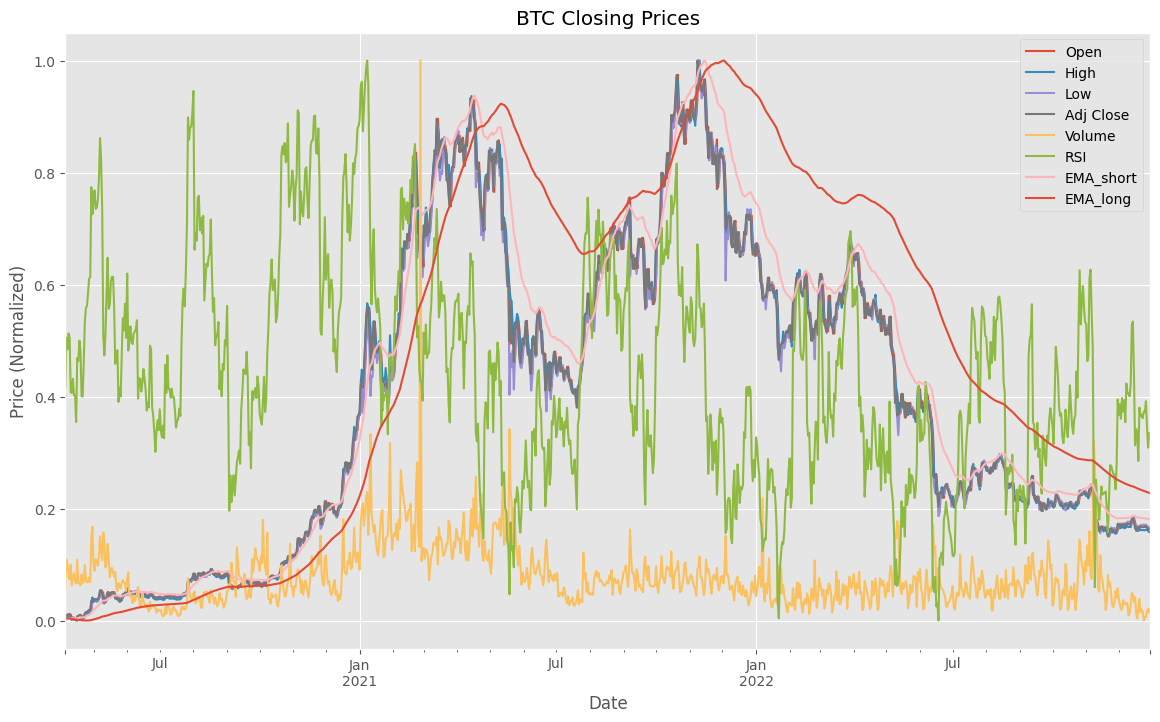

In [23]:
# Plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title("BTC Closing Prices")
plt.ylabel("Price (Normalized)")
plt.show()

### Functions to prepare the data for LSTM

In [24]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [25]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [30]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

### Splitting the Data

In [37]:
# How many periods looking back to learn
n_per_in  = 30

# How many periods to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df['Adj Close']), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))
print("x.shape",X.shape)
print("y.shape",y.shape)


x.shape (961, 30, 1)
y.shape (961, 10)


## Modeling - LSTM (RNN)

### Creating the Neural Network

In [39]:



# Step 6: Building the LSTM model (cont.)

model = Sequential()
model.add(LSTM(100, input_shape=(n_per_in, n_features), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(75, return_sequences=True, activation='tanh'))
model.add(Dropout(0.25))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['accuracy', 'mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 30, 12)            2064      
                                                                 
 lstm_2 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_3 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_4 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_5 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_6 (LSTM)               (None, 30, 12)            1

In [40]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [41]:
res = model.fit(X, y, epochs=800, batch_size=32, validation_split=0.1)

Epoch 1/800
27/27 [==============================] - 24s 206ms/step - loss: 0.0865 - accuracy: 0.1042 - val_loss: nan - val_accuracy: 0.0928
Epoch 2/800
27/27 [==============================] - 3s 115ms/step - loss: 0.0450 - accuracy: 0.0764 - val_loss: nan - val_accuracy: 0.0722
Epoch 3/800
27/27 [==============================] - 3s 118ms/step - loss: 0.0329 - accuracy: 0.0671 - val_loss: nan - val_accuracy: 0.0722
Epoch 4/800
27/27 [==============================] - 3s 102ms/step - loss: 0.0233 - accuracy: 0.0671 - val_loss: nan - val_accuracy: 0.0619
Epoch 5/800
27/27 [==============================] - 3s 94ms/step - loss: 0.0168 - accuracy: 0.0822 - val_loss: nan - val_accuracy: 0.0825
Epoch 6/800
27/27 [==============================] - 3s 97ms/step - loss: 0.0154 - accuracy: 0.0984 - val_loss: nan - val_accuracy: 0.0928
Epoch 7/800
27/27 [==============================] - 3s 95ms/step - loss: 0.0143 - accuracy: 0.0972 - val_loss: nan - val_accuracy: 0.1237
Epoch 8/800
27/27 [===

### Plotting the Accuracy and Loss

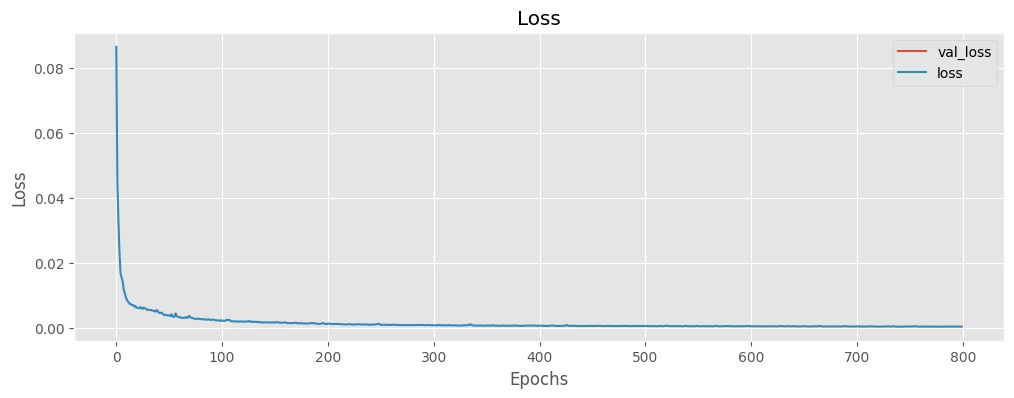

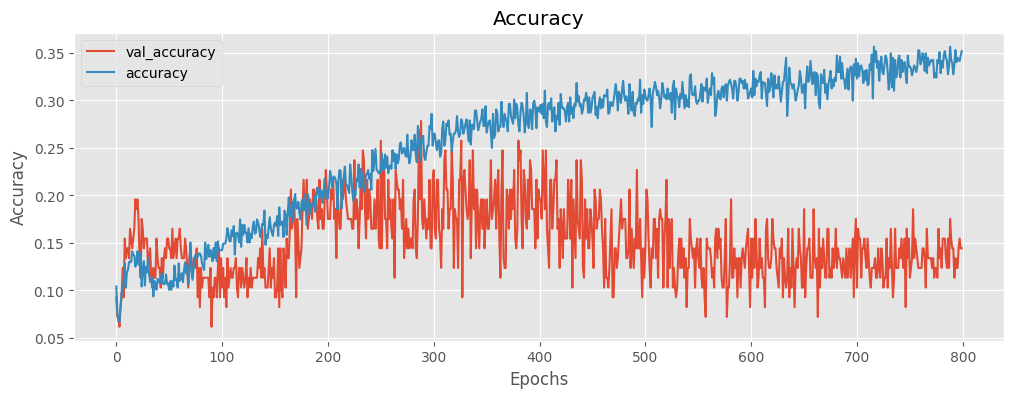

In [42]:
visualize_training_results(res)

## Visualizing the Predictions

### Validating the Model 
Plotting the difference between the Actual closing prices and the Predicted prices

In [45]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

1/1 [==============================] - 0s 76ms/step


ValueError: non-broadcastable output operand with shape (10,1) doesn't match the broadcast shape (10,6)

<Figure size 1200x500 with 0 Axes>

### Predicting/Forecasting the future prices

                  Close
2019-12-02  7750.527979
2019-12-03  7993.556731
2019-12-04  8048.777666
2019-12-05  8293.133372
2019-12-06  8278.055115
2019-12-07  8168.779239
2019-12-08  7833.326193
2019-12-09  7327.463403
2019-12-10  7053.108825
2019-12-11  6831.816325


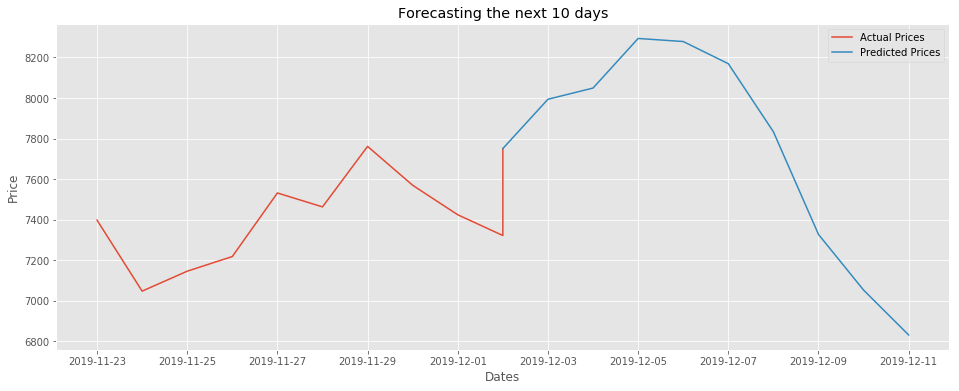

In [94]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()